In [1]:
import pandas as pd
import csv as csv
import numpy as np

In [2]:
def read_match_data(DATADIR,gameid):
    '''
    read_match_data(DATADIR,gameid):
    read all Metrica match data (tracking data for home & away teams, and ecvent data)
    '''
    tracking_home = tracking_data(DATADIR,gameid,'Home')
    tracking_away = tracking_data(DATADIR,gameid,'Away')
    events = read_event_data(DATADIR,gameid)
    return tracking_home,tracking_away,events


In [3]:
def read_event_data(DATADIR,game_id):
    '''
    read_event_data(DATADIR,game_id):
    read Metrica event data  for game_id and return as a DataFrame
    '''
    eventfile = '/Sample_Game_%d/Sample_Game_%d_RawEventsData.csv' % (game_id,game_id) # filename
    events = pd.read_csv('{}/{}'.format(DATADIR, eventfile)) # read data
    return events

In [4]:
def tracking_data(DATADIR,game_id,teamname):
    '''
    tracking_data(DATADIR,game_id,teamname):
    read Metrica tracking data for game_id and return as a DataFrame. 
    teamname is the name of the team in the filename. For the sample data this is either 'Home' or 'Away'.
    '''
    teamfile = '/Sample_Game_%d/Sample_Game_%d_RawTrackingData_%s_Team.csv' % (game_id,game_id,teamname)
    # First:  deal with file headers so that we can get the player names correct
    csvfile =  open('{}/{}'.format(DATADIR, teamfile), 'r') # create a csv file reader
    reader = csv.reader(csvfile) 
    teamnamefull = next(reader)[3].lower()
    print("Reading team: %s" % teamnamefull)
    # construct column names
    jerseys = [x for x in next(reader) if x != ''] # extract player jersey numbers from second row
    columns = next(reader)
    for i, j in enumerate(jerseys): # create x & y position column headers for each player
        columns[i*2+3] = "{}_{}_x".format(teamname, j)
        columns[i*2+4] = "{}_{}_y".format(teamname, j)
    columns[-2] = "ball_x" # column headers for the x & y positions of the ball
    columns[-1] = "ball_y"
    # Second: read in tracking data and place into pandas Dataframe
    tracking = pd.read_csv('{}/{}'.format(DATADIR, teamfile), names=columns, index_col='Frame', skiprows=3)
    return tracking


In [5]:
def to_metric_coordinates(data,field_dimen=(106.,68.) ):
    '''
    Convert positions from Metrica units to meters (with origin at centre circle)
    '''
    x_columns = [c for c in data.columns if c[-1].lower()=='x']
    y_columns = [c for c in data.columns if c[-1].lower()=='y']
    data[x_columns] = ( data[x_columns]-0.5 ) * field_dimen[0]
    data[y_columns] = -1 * ( data[y_columns]-0.5 ) * field_dimen[1]

    return data

In [6]:
# set up initial path to data
DATADIR = r'C:\Users\varshith\Desktop\Football anaylsis\sample-data-master\data'
game_id = 2 # let's look at sample match 2

In [7]:
events = read_event_data(DATADIR,game_id)
events.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.50,0.50,0.40,0.51
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,0.43,0.50,0.44,0.22
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,0.47,0.19,0.31,0.28
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,0.29,0.32,0.26,0.58


In [8]:
#stats
events['Type'].value_counts()

PASS              964
CHALLENGE         311
RECOVERY          248
BALL LOST         233
SET PIECE          80
BALL OUT           49
SHOT               24
FAULT RECEIVED     20
CARD                6
Name: Type, dtype: int64

In [9]:
events=to_metric_coordinates(events)
events.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.00,-0.00,-10.60,-0.68
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,-7.42,-0.00,-6.36,19.04
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,-3.18,21.08,-20.14,14.96
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,-22.26,12.24,-25.44,-5.44


In [10]:
# Get events by team
home_events = events[events['Team']=='Home']
away_events = events[events['Team']=='Away']

In [11]:
#stats of home_team
home_events['Type'].value_counts()

PASS              543
CHALLENGE         160
RECOVERY          135
BALL LOST         120
SET PIECE          34
BALL OUT           27
SHOT               13
FAULT RECEIVED      9
CARD                3
Name: Type, dtype: int64

In [12]:
#stats of away_team
away_events['Type'].value_counts()

PASS              421
CHALLENGE         151
BALL LOST         113
RECOVERY          113
SET PIECE          46
BALL OUT           22
SHOT               11
FAULT RECEIVED     11
CARD                3
Name: Type, dtype: int64

In [13]:
shots = events[events['Type']=='SHOT']
home_shots = home_events[home_events.Type=='SHOT']
away_shots = away_events[away_events.Type=='SHOT']
shots.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
83,Home,SHOT,OFF TARGET-OUT,1,4419,176.76,4443,177.72,Player5,NaN,-39.22,18.36,-55.12,2.72
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,-47.70,-3.40,-54.06,-2.04
252,Home,SHOT,ON TARGET-SAVED,1,16484,659.36,16499,659.96,Player10,NaN,-41.34,11.56,-48.76,0.68
297,Away,SHOT,BLOCKED,1,18515,740.60,18520,740.80,Player22,NaN,31.80,10.20,38.16,11.56
431,Home,SHOT,HEAD-OFF TARGET-OUT,1,27345,1093.80,27360,1094.40,Player3,NaN,-43.46,-6.12,-54.06,-6.12


In [14]:
print('*.........Home.........*')
print(home_shots['Subtype'].value_counts())
print('*........Away..........*')
print(away_shots['Subtype'].value_counts())

*.........Home.........*
ON TARGET-SAVED        4
HEAD-OFF TARGET-OUT    4
OFF TARGET-OUT         2
ON TARGET-GOAL         2
HEAD-ON TARGET-GOAL    1
Name: Subtype, dtype: int64
*........Away..........*
OFF TARGET-OUT         3
BLOCKED                2
ON TARGET-SAVED        2
ON TARGET-GOAL         2
HEAD-OFF TARGET-OUT    1
OFF TARGET-HEAD-OUT    1
Name: Subtype, dtype: int64


In [15]:
home_shots['From'].value_counts() 

Player9     4
Player10    3
Player5     2
Player12    1
Player4     1
Player7     1
Player3     1
Name: From, dtype: int64

In [16]:
home_goals = home_shots[home_shots['Subtype'].str.contains('-GOAL')].copy()
away_goals = away_shots[away_shots['Subtype'].str.contains('-GOAL')].copy()

In [17]:
home_goals


,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,-47.70,-3.40,-54.06,-2.04
1118,Home,SHOT,HEAD-ON TARGET-GOAL,2,73983,2959.32,73995,2959.80,Player9,NaN,47.70,-1.36,54.06,-2.04
1723,Home,SHOT,ON TARGET-GOAL,2,121027,4841.08,121055,4842.20,Player12,NaN,30.74,-5.44,54.06,-2.72


In [18]:
away_goals 

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
823,Away,SHOT,ON TARGET-GOAL,1,53049,2121.96,53075,2123.00,Player24,NaN,44.52,2.72,54.06,1.36
1671,Away,SHOT,ON TARGET-GOAL,2,115009,4600.36,115024,4600.96,Player20,NaN,-40.28,-1.36,-55.12,-2.72


In [19]:
home_goals['Minute']=home_goals['Start Time [s]']/60.
home_goals['Minute']

198      8.134667
1118    49.322000
1723    80.684667
Name: Minute, dtype: float64

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation



def plot_pitch( field_dimen = (106.0,68.0), field_color ='green', linewidth=2, markersize=20):
    fig,ax = plt.subplots(figsize=(12,8)) # create a figure 
    # decide what color we want the field to be. Default is green, but can also choose white
    if field_color=='green':
        ax.set_facecolor('mediumseagreen')
        lc = 'whitesmoke' # line color
        pc = 'w' # 'spot' colors
    elif field_color=='white':
        lc = 'k'
        pc = 'k'
    # ALL DIMENSIONS IN m
    border_dimen = (3,3) # include a border arround of the field of width 3m
    meters_per_yard = 0.9144 # unit conversion from yards to meters
    half_pitch_length = field_dimen[0]/2. # length of half pitch
    half_pitch_width = field_dimen[1]/2. # width of half pitch
    signs = [-1,1] 
    # Soccer field dimensions typically defined in yards, so we need to convert to meters
    goal_line_width = 8*meters_per_yard
    box_width = 20*meters_per_yard
    box_length = 6*meters_per_yard
    area_width = 44*meters_per_yard
    area_length = 18*meters_per_yard
    penalty_spot = 12*meters_per_yard
    corner_radius = 1*meters_per_yard
    D_length = 8*meters_per_yard
    D_radius = 10*meters_per_yard
    D_pos = 12*meters_per_yard
    centre_circle_radius = 10*meters_per_yard
    # plot half way line # center circle
    ax.plot([0,0],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
    ax.scatter(0.0,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
    y = np.linspace(-1,1,50)*centre_circle_radius
    x = np.sqrt(centre_circle_radius**2-y**2)
    ax.plot(x,y,lc,linewidth=linewidth)
    ax.plot(-x,y,lc,linewidth=linewidth)
    for s in signs: # plots each line seperately
        # plot pitch boundary
        ax.plot([-half_pitch_length,half_pitch_length],[s*half_pitch_width,s*half_pitch_width],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
        # goal posts & line
        ax.plot( [s*half_pitch_length,s*half_pitch_length],[-goal_line_width/2.,goal_line_width/2.],pc+'s',markersize=6*markersize/20.,linewidth=linewidth)
        # 6 yard box
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[box_width/2.,box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[-box_width/2.,-box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*box_length,s*half_pitch_length-s*box_length],[-box_width/2.,box_width/2.],lc,linewidth=linewidth)
        # penalty area
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[area_width/2.,area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[-area_width/2.,-area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*area_length,s*half_pitch_length-s*area_length],[-area_width/2.,area_width/2.],lc,linewidth=linewidth)
        # penalty spot
        ax.scatter(s*half_pitch_length-s*penalty_spot,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
        # corner flags
        y = np.linspace(0,1,50)*corner_radius
        x = np.sqrt(corner_radius**2-y**2)
        ax.plot(s*half_pitch_length-s*x,-half_pitch_width+y,lc,linewidth=linewidth)
        ax.plot(s*half_pitch_length-s*x,half_pitch_width-y,lc,linewidth=linewidth)
        # draw the D
        y = np.linspace(-1,1,50)*D_length # D_length is the chord of the circle that defines the D
        x = np.sqrt(D_radius**2-y**2)+D_pos
        ax.plot(s*half_pitch_length-s*x,y,lc,linewidth=linewidth)
        
    # remove axis labels and ticks
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    # set axis limits
    xmax = field_dimen[0]/2. + border_dimen[0]
    ymax = field_dimen[1]/2. + border_dimen[1]
    ax.set_xlim([-xmax,xmax])
    ax.set_ylim([-ymax,ymax])
    ax.set_axisbelow(True)
    return fig,ax

def plot_frame( hometeam, awayteam, figax=None, team_colors=('r','b'), field_dimen = (106.0,68.0), include_player_velocities=False, PlayerMarkerSize=10, PlayerAlpha=0.7, annotate=False ):
    if figax is None: # create new pitch 
        fig,ax = plot_pitch( field_dimen = field_dimen )
    else: # overlay on a previously generated pitch
        fig,ax = figax # unpack tuple
    # plot home & away teams in order
    for team,color in zip( [hometeam,awayteam], team_colors) :
        x_columns = [c for c in team.keys() if c[-2:].lower()=='_x' and c!='ball_x'] # column header for player x positions
        y_columns = [c for c in team.keys() if c[-2:].lower()=='_y' and c!='ball_y'] # column header for player y positions
        ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
        if annotate:
            [ ax.text( team[x]+0.5, team[y]+0.5, x.split('_')[1], fontsize=10, color=color  ) for x,y in zip(x_columns,y_columns) if not ( np.isnan(team[x]) or np.isnan(team[y]) ) ] 
    # plot ball
    ax.plot( hometeam['ball_x'], hometeam['ball_y'], 'ko', MarkerSize=6, alpha=1.0, LineWidth=0)
    return fig,ax
    


def plot_events( events, figax=None, field_dimen = (106.0,68), indicators = ['Marker','Arrow'], color='r', marker_style = 'o', alpha = 0.5, annotate=False):
    if figax is None: # create new pitch 
        fig,ax = plot_pitch( field_dimen = field_dimen )
    else: # overlay on a previously generated pitch
        fig,ax = figax 
    for i,row in events.iterrows():
        if 'Marker' in indicators:
            ax.plot(  row['Start X'], row['Start Y'], color+marker_style, alpha=alpha )
        if 'Arrow' in indicators:
            ax.annotate("", xy=row[['End X','End Y']], xytext=row[['Start X','Start Y']], alpha=alpha, arrowprops=dict(alpha=alpha,width=0.5,headlength=4.0,headwidth=4.0,color=color),annotation_clip=False)
        if annotate:
            textstring = row['Type'] + ': ' + row['From']
            ax.text( row['Start X'], row['Start Y'], textstring, fontsize=10, color=color)
    return fig,ax





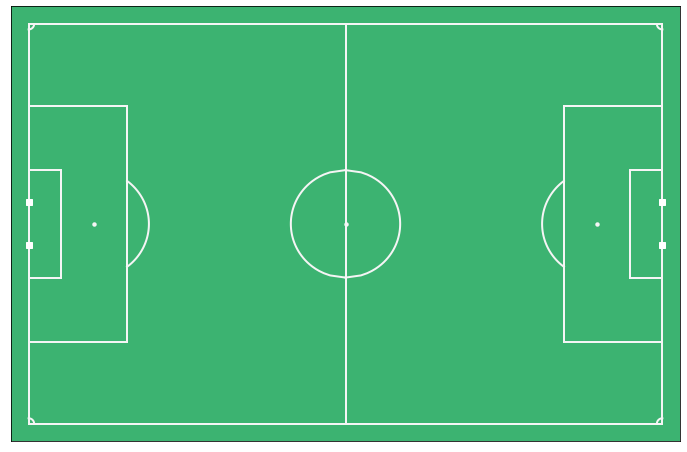

In [21]:
fig,ax=plot_pitch()

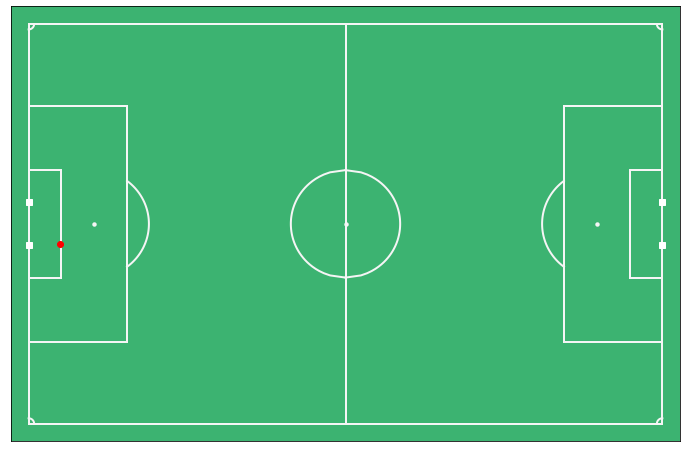

In [22]:
ax.plot( events.loc[198]['Start X'], events.loc[198]['Start Y'], 'ro')
fig

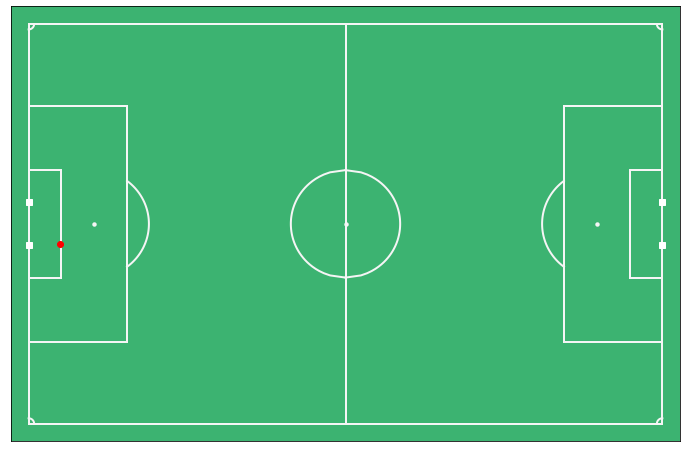

In [23]:
ax.annotate("", xy=events.loc[197][['End X','End Y']], xytext=events.loc[198][['Start X','Start Y']], alpha=0.6, arrowprops=dict(arrowstyle="->",color='r'))
fig

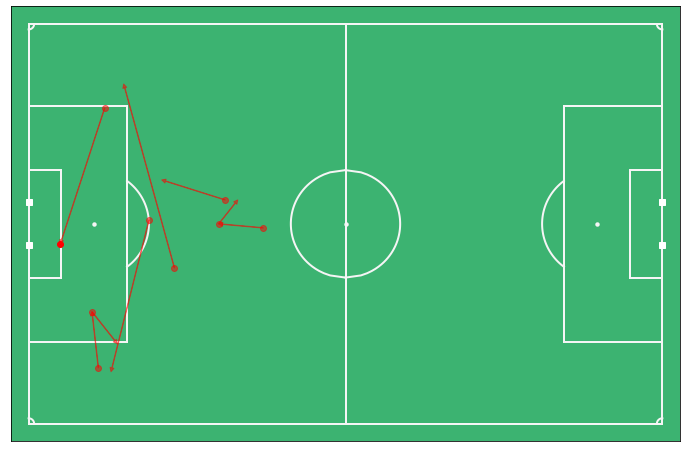

In [24]:
# plot passing move in run up to goal
plot_events( events.loc[190:197], indicators = ['Marker','Arrow'],figax=(fig,ax) )
fig

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

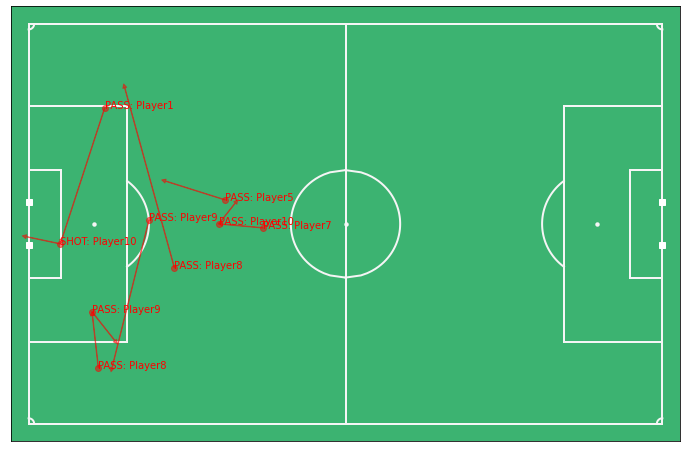

In [25]:
#player passes in run up to goal
plot_events( events.loc[190:198], indicators = ['Marker','Arrow'],annotate="True" )

In [26]:
#### TRACKING DATA ####

# READING IN TRACKING DATA
tracking_home = tracking_data(DATADIR,game_id,'Home')
tracking_away = tracking_data(DATADIR,game_id,'Away')

Reading team: home
Reading team: away


In [27]:
# Look at the column namems
print( tracking_home.columns )

Index(['Period', 'Time [s]', 'Home_11_x', 'Home_11_y', 'Home_1_x', 'Home_1_y',
       'Home_2_x', 'Home_2_y', 'Home_3_x', 'Home_3_y', 'Home_4_x', 'Home_4_y',
       'Home_5_x', 'Home_5_y', 'Home_6_x', 'Home_6_y', 'Home_7_x', 'Home_7_y',
       'Home_8_x', 'Home_8_y', 'Home_9_x', 'Home_9_y', 'Home_10_x',
       'Home_10_y', 'Home_12_x', 'Home_12_y', 'Home_13_x', 'Home_13_y',
       'Home_14_x', 'Home_14_y', 'ball_x', 'ball_y'],
      dtype='object')


In [28]:
# Convert positions from metrica units to meters 
tracking_home = to_metric_coordinates(tracking_home)
tracking_away = to_metric_coordinates(tracking_away)

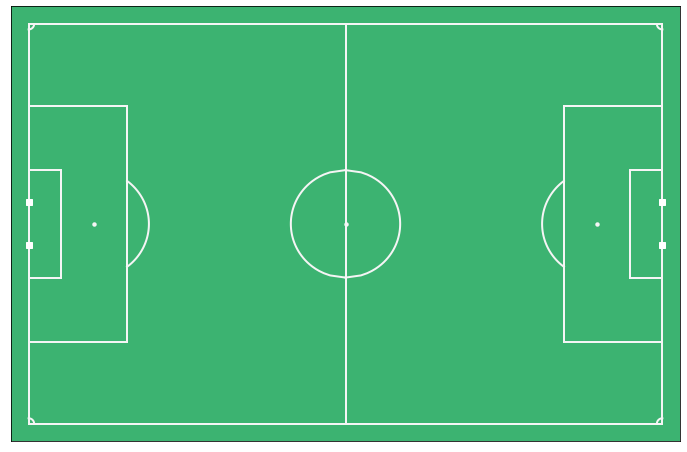

In [29]:
fig,ax=plot_pitch()

<ipython-input-30-4841f7ede875>:3: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( tracking_home['Home_11_x'].iloc[:1500], tracking_home['Home_11_y'].iloc[:1500], 'r.', MarkerSize=1)


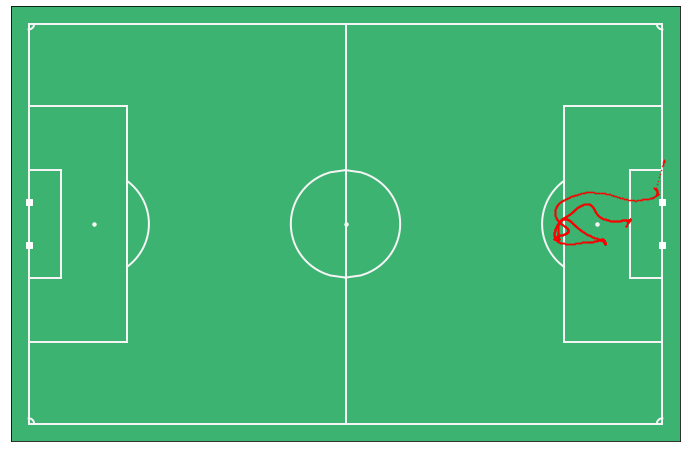

In [30]:
#plotting tracking data of player11(Goal keeper) of home team 
#first 60 seconds i.e 60*25 = 1500 frames
ax.plot( tracking_home['Home_11_x'].iloc[:1500], tracking_home['Home_11_y'].iloc[:1500], 'r.', MarkerSize=1)
fig

<ipython-input-31-db2ad92fdb1a>:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( tracking_home['Home_1_x'].iloc[:1500], tracking_home['Home_1_y'].iloc[:1500], 'b.', MarkerSize=1)
<ipython-input-31-db2ad92fdb1a>:3: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( tracking_home['Home_2_x'].iloc[:1500], tracking_home['Home_2_y'].iloc[:1500], 'g.', MarkerSize=1)
<ipython-input-31-db2ad92fdb1a>:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( tracking_home['Home_3_x'].iloc[:1500], tracking_home['Home_3_y'].iloc[:1500], 'k.', MarkerSize=1)
<ipython-input-31-db2ad92fdb1a>:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases lat

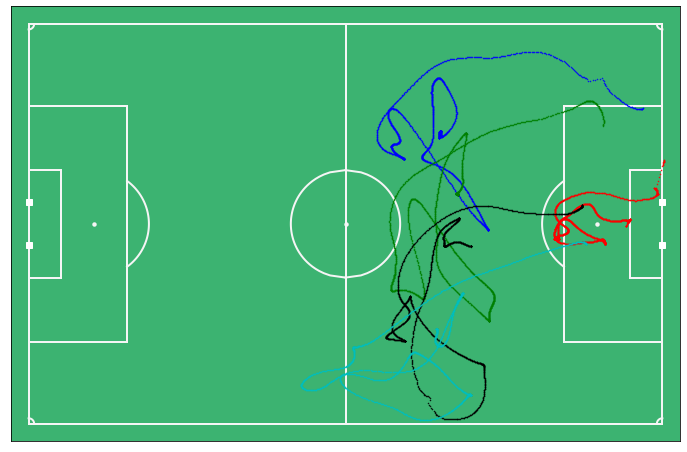

In [31]:
#plotting tracking data of player 1-4 (defenders) of home team
ax.plot( tracking_home['Home_1_x'].iloc[:1500], tracking_home['Home_1_y'].iloc[:1500], 'b.', MarkerSize=1)
ax.plot( tracking_home['Home_2_x'].iloc[:1500], tracking_home['Home_2_y'].iloc[:1500], 'g.', MarkerSize=1)
ax.plot( tracking_home['Home_3_x'].iloc[:1500], tracking_home['Home_3_y'].iloc[:1500], 'k.', MarkerSize=1)
ax.plot( tracking_home['Home_4_x'].iloc[:1500], tracking_home['Home_4_y'].iloc[:1500], 'c.', MarkerSize=1)
fig

<ipython-input-20-09dbf66a63b8>:90: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
<ipython-input-20-09dbf66a63b8>:90: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
<ipython-input-20-09dbf66a63b8>:94: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( hometeam['ball_x'], hometeam['ball_y'], 'ko', MarkerSize=6, alpha=1.0, LineWidth=0)


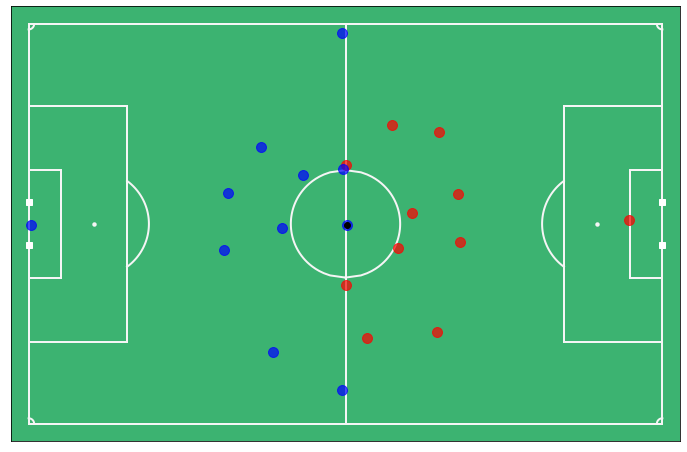

In [32]:
# plotting player positions at ,atckick-off
KO_Frame = events.loc[0]['Start Frame']
fig,ax = plot_frame( tracking_home.loc[KO_Frame], tracking_away.loc[KO_Frame] )


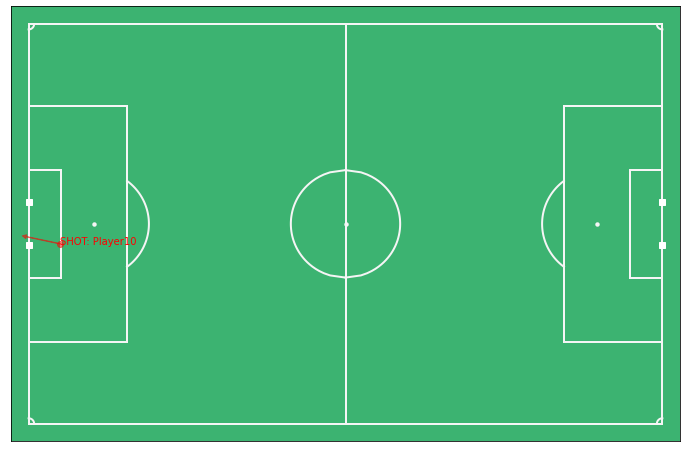

In [33]:
# PLOT POISTIONS AT GOAL
fig,ax = plot_events( events.loc[198:198], indicators = ['Marker','Arrow'], annotate=True )

<ipython-input-20-09dbf66a63b8>:90: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
<ipython-input-20-09dbf66a63b8>:90: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( team[x_columns], team[y_columns], color+'o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
<ipython-input-20-09dbf66a63b8>:94: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot( hometeam['ball_x'], hometeam['ball_y'], 'ko', MarkerSize=6, alpha=1.0, LineWidth=0)


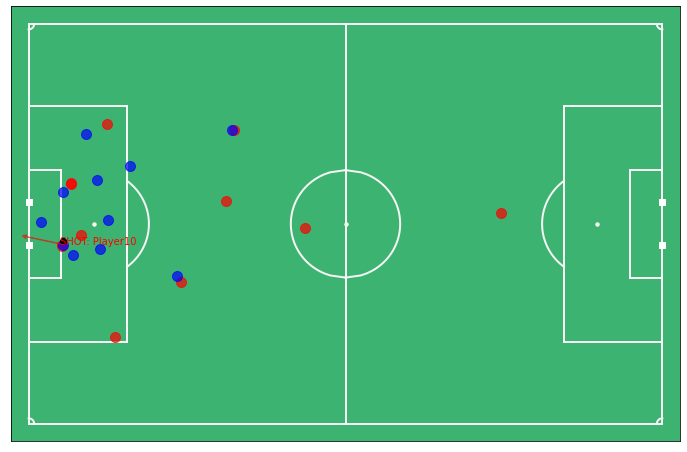

In [34]:
#plotting position of players[ Can Analyze data such as "what was the critical pass that led to goal"]
GoalFrame = events.loc[198]['Start Frame']
fig,ax = plot_frame(tracking_home.loc[GoalFrame], tracking_away.loc[GoalFrame], figax = (fig,ax) )
fig